<a href="https://colab.research.google.com/github/stephenbeckr/numerical-analysis-class/blob/master/Demos/Ch4_ImproperIntegrals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improper integrals
These are integrals where something is unbounde, like an **unbounded domain** 
$$\int_0^\infty \frac{1}{1+x^2}\,dx$$
or an **unbounded integrand** like
$$\int_0^1 \frac{1}{\sqrt{x}}\,dx$$

In [18]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["figure.figsize"] = [8,6] # or 7, 4 or 10,8
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["lines.markersize"] = 4
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams.update({'font.size': 20})

### Unbounded domains

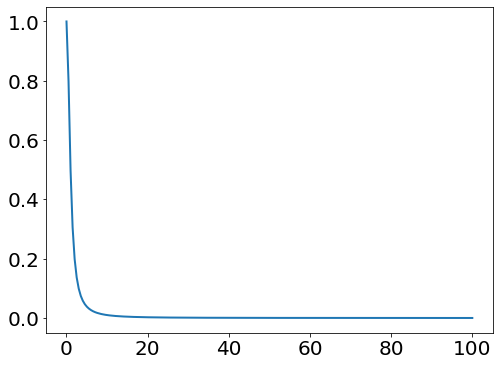

In [38]:
f = lambda x : 1/(1+x**2)
F = lambda x : np.arctan(x)  # antiderivative
a,b = 0, np.inf

xGrid = np.linspace(0,100,200)
plt.plot( xGrid, f(xGrid) );

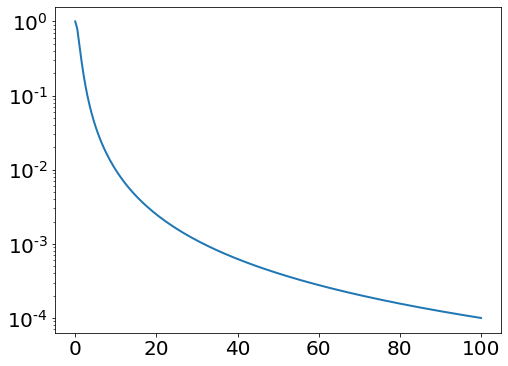

In [39]:
plt.semilogy( xGrid, f(xGrid) );

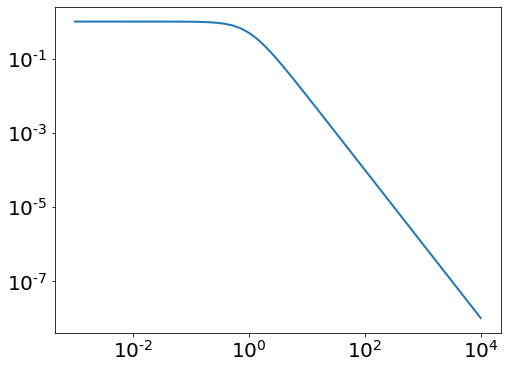

In [42]:
xGrid = np.logspace(-3,4,50)
plt.loglog( xGrid, f(xGrid) );

In [20]:
I = F(b) - F(a) # true integral
Q,errEstimate = quad(f,a,b) # scipy's approximation
print(f'True integral is {I:.8f}, estimate is {Q:.8f}, error is {abs(I-Q):2e}')

True integral is 1.57079633, estimate is 1.57079633, error is 0.000000e+00


Not bad! How did it do that? Can we recreate it?

Let's try some of our techniques.  
**Technique #1** in the notes is *Gauss-Hermite* or *Gauss-Laguerre*, and will be explored on Homework 7.

**Technique #2** is the simplest, and not always a good idea: we just change $b=\infty$ to $b=R$ for a large $R$

In [22]:
R   = 1e4;
Q,errEstimate = quad(f,a,R) # use [a,R] instead of [a,b) (where b=infinity)
print(f'True integral is {I:.8f}, estimate is {Q:.8f}, error is {abs(I-Q):2e}')

True integral is 1.57079633, estimate is 1.57069633, error is 1.000000e-04


That wasn't so accurate. Let's increate the radius $R$:

In [22]:
R   = 1e6;
Q,errEstimate = quad(f,a,R) # use [a,R] instead of [a,b) (where b=infinity)
print(f'True integral is {I:.8f}, estimate is {Q:.8f}, error is {abs(I-Q):2e}')

... that was worse!

Let's try **Technique #3**, where we do a change of variables for one of the integrals
$$\int_0^\infty f(x)\,dx = \int_0^R f(x)\,dx + \int_R^\infty f(x)\,dx$$
and for this second integral, let's write $t=1/x$ so $dx = -t^{-2}dt$ and $x=R$ becomes $t=1/R$ and $x=\infty$ becomes $t=0$

In [23]:
R   = 10  # pick a **small** R now
Q1,errEstimate = quad(f,a,R)

g = lambda t : f(1/t)/(t**2)
Q2,errEstimate = quad(g,0,1/R)
Q   = Q1 + Q2
print(f'True integral is {I:.8f}, estimate is {Q:.8f}, error is {abs(I-Q):2e}')

True integral is 1.57079633, estimate is 1.57079633, error is 8.881784e-16


... and it worked! (We relied on the fact that `quad` can handle unbounded integrands...)

Now **Technique #4**, comparison with a known function,
$$\int_0^\infty f(x)\,dx = \int_0^R f(x)\,dx + \int_R^\infty \underbrace{f(x) - \phi(x)}_{g(x)}\,dx + \int_R^\infty \phi(x)\,dx$$

and we can approximate 
$$\int_R^\infty \underbrace{f(x) - \phi(x)}_{g(x)}\,dx 
\approx \int_R^M \underbrace{f(x) - \phi(x)}_{g(x)}\,dx 
$$
for some large $M$.

(Why did we have to do that first $\int_0^R$? because the $\phi$ we chose has a singular at $0$, so we wanted to avoid integrating near $0$)

In [24]:
R   = 10  # pick a **small** R now
Q1,errEstimate = quad(f,a,R)

phi = lambda x : 1/(x**2)  # our "known function" that has a known antiderivative
Phi = lambda x : -1/x      # the antiderivative

g = lambda x : f(x) - phi(x) 
M   = 1e4; # now we don't have to take it quite as large
Q2,errEstimate = quad(g,R,M)

Q3 = Phi(b) - Phi(R)  # compensate

Q   = Q1 + (Q2+Q3)
print(f'True integral is {I:.8f}, estimate is {Q:.8f}, error is {abs(I-Q):2e}')

True integral is 1.57079633, estimate is 1.57079633, error is 3.337330e-13


and it worked also! Why does it work?  Let's plot $f$ and $f-\phi$

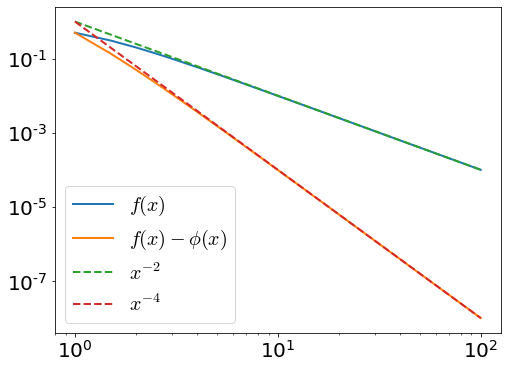

In [26]:
xGrid = np.linspace(1,100,200)
plt.loglog( xGrid, f(xGrid),label='$f(x)$' );
plt.loglog( xGrid, np.abs(g(xGrid)),label='$f(x)-\phi(x)$' );
plt.loglog( xGrid, 1/xGrid**2,'--',label='$x^{-2}$')
plt.loglog( xGrid, 1/xGrid**4,'--',label='$x^{-4}$')
plt.legend();

Now let's try **Technique #5** which is the double exponential transformation.
$$\int_{0}^\infty f(x)\,dx = \frac{\pi}{2}\int_{0}^\infty f(x(t)) \text{cosh}\left(\frac{\pi}{2}\text{sinh}(t)\right) \cdot \text{cosh}(t)\,dt$$
where
$$x(t) = \text{sinh}\left( \frac{\pi}{2}\text{sinh}(t)\right)$$

In [32]:
from numpy import pi, sinh, cosh
ft = lambda t : f( sinh( pi/2*sinh(t)) )
g = lambda t : pi/2 * f( sinh( pi/2*sinh(t)) ) * cosh(pi/2*sinh(t))*cosh(t)

R = 4
Q,errEstimate = quad( g, 0, R)
print(f'True integral is {I:.8f}, estimate is {Q:.8f}, error is {abs(I-Q):2e}')

True integral is 1.57079633, estimate is 1.57079633, error is 0.000000e+00


... that worked well too!  We can see why with a plot: the new integral goes to zero very fast. In fact, we can't even choose $R=10$ because then we get underflow

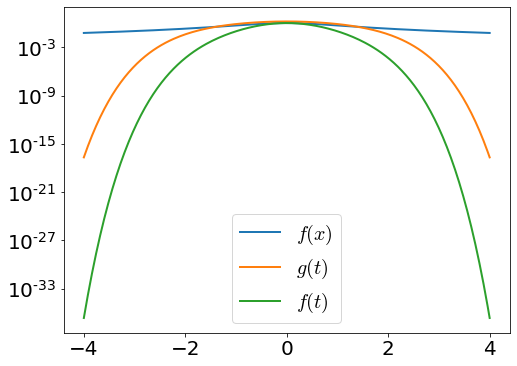

In [35]:
xGrid = np.linspace(-4,4,200)
plt.semilogy( xGrid, f(xGrid),label='$f(x)$' );
plt.semilogy( xGrid, np.abs(g(xGrid)),label='$g(t)$' );
plt.semilogy( xGrid, np.abs(ft(xGrid)),label='$f(t)$' );
plt.legend();

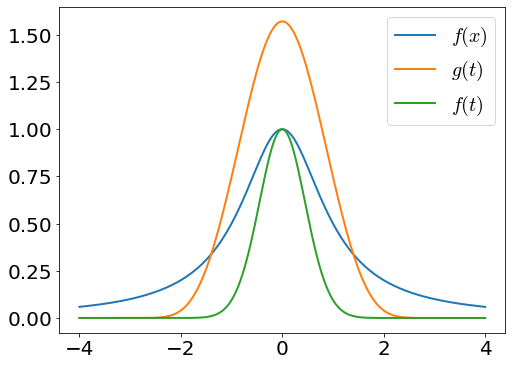

In [37]:
xGrid = np.linspace(-4,4,200)
plt.plot( xGrid, f(xGrid),label='$f(x)$' );
plt.plot( xGrid, g(xGrid),label='$g(t)$' ); # compensates for the area with the dx(dt) formula
plt.plot( xGrid, ft(xGrid),label='$f(t)$' ); # squished version of f
plt.legend();

## Unbounded integrands (e.g., left-end point singularity)

Not yet implemented. The novel techniques are the Taylor series based ones